## Classification

In this notebook we will classify between spilled and not-spilled cup.

In [98]:
import torch
import torchvision
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

### Loading and preprocesing data
We are using a small data set containing 61 images almost equally distibuted among both classes.

In [99]:
data_dir = 'cup_data/'

In [100]:
# Transforms 
transforms = transforms.Compose([transforms.Resize(256),
                                   transforms.RandomCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

In [101]:
# Loading and applying transforms
data = datasets.ImageFolder(data_dir, transform=transforms)
class_names = data.classes
class_names

['nospill', 'spill']

**Split data into train and validation**

In [102]:
# split data in train and validaion
bs=4
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data, batch_size=bs, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(data, batch_size=bs,
                                                sampler=valid_sampler)

### Visulaize Images

In [103]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

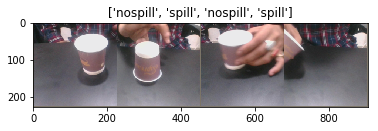

In [104]:
# get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

### Model

We are going to use Transfer learning, because we have very small dataset.
We will use resnet18

In [105]:
model = models.densenet121(pretrained=True)

In [106]:
# Freeze model parameters, so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Change fc layers accoring to need
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

### Training

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

In [109]:
epoches = 10
steps = 0
running_loss = 0
print_every = 5


for epoch in range(epoches):
    steps += 1
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients to stop accumulation
        optimizer.zero_grad()
        
        # logits
        logps = model.forward(inputs)
        # labels
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validation_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(validation_loader):.3f}")
            running_loss = 0
            model.train()
        

Epoch 5/10.. Train loss: 4.630.. Test loss: 0.678.. Test accuracy: 0.500
Epoch 5/10.. Train loss: 0.113.. Test loss: 0.516.. Test accuracy: 0.750
Epoch 5/10.. Train loss: 0.125.. Test loss: 0.421.. Test accuracy: 0.833
Epoch 5/10.. Train loss: 0.068.. Test loss: 0.204.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.025.. Test loss: 0.216.. Test accuracy: 0.917
Epoch 5/10.. Train loss: 0.019.. Test loss: 0.157.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.015.. Test loss: 0.092.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.083.. Test loss: 0.222.. Test accuracy: 0.917
Epoch 5/10.. Train loss: 0.043.. Test loss: 0.095.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.067.. Test loss: 0.100.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.123.. Test loss: 0.089.. Test accuracy: 1.000
Epoch 5/10.. Train loss: 0.027.. Test loss: 0.149.. Test accuracy: 0.917
Epoch 5/10.. Train loss: 0.140.. Test loss: 0.149.. Test accuracy: 1.000
Epoch 10/10.. Train loss: 4.814.. Test loss: 0.146.

### Inference